In [1]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.datasets import WikiCS
from torch_geometric.data import NeighborSampler

In [2]:
dataset = WikiCS(root='./data')[0]

print(len(dataset))

7


In [3]:
dataset

Data(edge_index=[2, 297110], stopping_mask=[11701, 20], test_mask=[11701], train_mask=[11701, 20], val_mask=[11701, 20], x=[11701, 300], y=[11701])

In [4]:
dataset.x

tensor([[-0.0204,  0.0646,  0.0197,  ..., -0.0754, -0.1124,  0.1514],
        [-0.0438, -0.0317, -0.0082,  ..., -0.0658,  0.0643, -0.0588],
        [-0.1127,  0.0098,  0.1422,  ...,  0.1398, -0.0195,  0.0451],
        ...,
        [ 0.0368,  0.0305, -0.0285,  ..., -0.0600, -0.0721,  0.1510],
        [-0.0329,  0.0195, -0.1278,  ..., -0.1751, -0.0754,  0.1974],
        [ 0.0530,  0.0480, -0.0100,  ...,  0.0250, -0.0308,  0.0691]])

In [5]:
NUM_CLASSES = len(dataset.y.unique())

In [6]:
NUM_CLASSES

10

In [7]:
train_loader = NeighborSampler(edge_index=dataset.edge_index, sizes=[20, 10], batch_size=256, shuffle=True)

test_loader = NeighborSampler(edge_index=dataset.edge_index, sizes=[-1, -1], batch_size=2048)

In [9]:
sample_batch = next(iter(train_loader))

sample_batch

# see doc https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html

# batch_size, n_id, list of bipartite graphs 

# n_id: all nodes involved in the computation
# edge_index: the bipartite edges between source and target nodes
# e_id: the IDs of original edges in the full graph
# size holds the shape of the bipartite graph

# For each bipartite graph, target nodes are also included at the beginning of the list of source nodes

(256,
 tensor([ 2949,  4921,  3912,  ...,  2000, 11555,  2457]),
 [EdgeIndex(edge_index=tensor([[ 256,  257,   95,  ..., 2528, 2891, 5526],
          [   0,    0,    1,  ..., 2040, 2040, 2040]]), e_id=tensor([261570,  75748,  17748,  ..., 138962,  43663,  65528]), size=(5527, 2041)),
  EdgeIndex(edge_index=tensor([[ 256,  257,   95,  ..., 2040,  257, 1644],
          [   0,    0,    1,  ...,  253,  255,  255]]), e_id=tensor([261570,  75748,  17748,  ..., 167341,  75744, 170487]), size=(2041, 256))])

In [10]:
from torch_geometric.nn import SAGEConv

In [11]:
class WikiNode(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.convs = nn.ModuleList()
        
        self.convs.append(SAGEConv(dataset.num_features, 128))
        
        self.convs.append(SAGEConv(128, 128))
        
        self.fc = torch.nn.Linear(128, NUM_CLASSES)
        
    def forward(self, x, adjs):
        
        for i, (edge_index, _, size) in enumerate(adjs):
                        
            x_target = x[:size[1]] # Target nodes are always placed first.
            
            # aggregate from neighbors
            x = self.convs[i]((x, x_target), edge_index)
                        
            x = F.relu(x)
            
        return self.fc(x)
    
    def full_forward(self, x, edge_index):
        
        for conv in self.convs:
            
            x = conv(x, edge_index)
            
            features = x
            
            x = F.relu(x)
            
        return self.fc(x), features

In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
node_clf = WikiNode().to(DEVICE)

opt = torch.optim.Adam(node_clf.parameters(), weight_decay=0.001)

In [14]:
train_mask = dataset.train_mask[:, 0]

test_mask = dataset.test_mask

In [17]:
@torch.no_grad()
def masked_acc(logits, y, mask):
    
    a_max = torch.argmax(logits, dim=-1)
    
    eq = (a_max == y).float() * mask.float()
            
    return eq.sum() / mask.float().sum()

In [18]:
def masked_cross_entropy(logits, y, mask):
    
    masked_y = y.masked_fill(mask == False, value=-1)
    
    loss = F.cross_entropy(logits, masked_y, ignore_index=-1)
    
    return loss

In [19]:
def train_one_epoch():
        
    losses = []

    for bs, n_id, adjs in train_loader:

        # all x involved in the computation graph
        x_i = dataset.x[n_id].to(DEVICE)
        
        # put all adjs to device
        adjs = [adj.to(DEVICE) for adj in adjs]

        # prediction
        logits = node_clf(x_i, adjs) # [bs, num_classes]

        # train mask
        train_mask_i = train_mask[n_id][:bs].to(DEVICE)

        # y_i
        y_i = dataset.y[n_id][:bs].to(DEVICE)

        # compute masked loss
        loss = masked_cross_entropy(logits, y_i, train_mask_i)

        # backprop + update
        loss.backward()
        opt.step()
        opt.zero_grad()

        losses.append(loss.item())

    return np.array(losses).mean()

In [20]:
@torch.no_grad()
def evaluate():
        
    accuracies = []

    for bs, n_id, adjs in test_loader:

        # all x involved in the computation graph
        x_i = dataset.x[n_id].to(DEVICE)
        
        # put all adjs to device
        adjs = [adj.to(DEVICE) for adj in adjs]
                
        # prediction
        logits = node_clf(x_i, adjs) # [bs, num_classes]

        # train mask
        test_mask_i = test_mask[n_id][:bs].to(DEVICE)

        # y_i
        y_i = dataset.y[n_id][:bs].to(DEVICE)
                
        # compute accuracy
        acc = masked_acc(logits, y_i, test_mask_i)

        accuracies.append(acc.item())

    return np.array(accuracies).mean()

In [21]:
for i in range(15):
    
    loss = train_one_epoch()
    
    acc = evaluate()
    
    print(f'loss = {loss: .3f}\t acc = {acc: .3f}')

loss =  2.054	 acc =  0.509
loss =  1.462	 acc =  0.602
loss =  1.108	 acc =  0.642
loss =  0.954	 acc =  0.647
loss =  0.824	 acc =  0.712
loss =  0.720	 acc =  0.724
loss =  0.648	 acc =  0.713
loss =  0.614	 acc =  0.739
loss =  0.577	 acc =  0.745
loss =  0.499	 acc =  0.750
loss =  0.472	 acc =  0.750
loss =  0.433	 acc =  0.746
loss =  0.378	 acc =  0.762
loss =  0.334	 acc =  0.758
loss =  0.334	 acc =  0.761


### Visualize features

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [23]:
np.random.seed(10)

In [24]:
perm = np.random.permutation(len(dataset.x))[:1000]

In [25]:
dataset.to(DEVICE)

with torch.no_grad():
    _, out = node_clf.full_forward(dataset.x, dataset.edge_index)
    
    out = out.cpu().numpy()

In [26]:
out = out[perm]
c = dataset.y.cpu().numpy()[perm]

In [27]:
projected_gcn = TSNE(n_components=2).fit_transform(out)

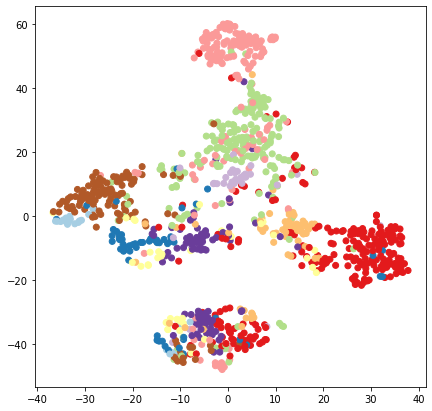

In [28]:
plt.figure(figsize=(7, 7))
plt.scatter(x=projected_gcn[:, 0], y=projected_gcn[:, 1], c=c, cmap='Paired')